# QUBO:  A Gentle Introduction to Quantum Computing, Graph Theory, and Optimization

This tutorial is designed for the beginner Qiskitter to gain insight in how quantum computing, graph theory, and optimization, can be used to solve a QUBO (Quantum Unconstrained Binary Optimization) problem. We do a deep dive into a basic implementation in Qiskit of a scheduling problem detailed in a PennyLane YouTube Tutorial. The video gives a great explanation of the problem and how to create the code.  In order to gain insight, there is a need to go into further detail on certain aspects of the solution approach and to do some analysis on the results, both which we aim to do here.  Here are the links to the PennyLane video and the corresponding code.

(https://www.youtube.com/watch?v=YJhv4bhNf6M)

(https://github.com/XanaduAI/PLC-YouTube-tutorials/blob/main/how_to_solve_qubo.ipynb)

## Why Focus on this basic Event Scheduling problem?

1. The scheduling problem as presented is a relatable graph problem and understanding the approach to the solution is manageable without introducing intimidating concepts.
2. The problem can be scaled or altered easily for relevant applications for an individual's needs.
3. The purpose of the Hamilitonian is made apparent easily while avoiding discussion of quantum physics and chemistry.
4. Basic parameterized quantum circuits are introduced while avoiding terminology including Ansatz circuits or Machine Learning. 
5. There is no discussion of advanced quantum optimization algorithms such as QAOA, VQE, or quantum annealing.
6. As a result, the buildup to use optimization in order to find the final parameters that minimize the Hamiltonian to solve the graph problem occurs seemlessly. 
7. Finally, there is minimal coding required (< 50 lines of code!).  Combined with the other factors, time is saved on debugging and learning new concepts, both of which can be overwhelming.  Consequently, one can spend more time on the understanding of the steps involved to create the solution, analysis of the results, and experimentation with variations.

## Objectives of this tutorial

1.  Understand how to formulate a QUBO problem.
2.  Create a Hamiltonian operator based on the obtained objective function. 
3.  Create a function to calculate the Hamiltonian using a parameterized quantum circuit. 
4.  Use classical optimization algorithms to iterate the parameters to find the global minimum.
5.  Perform 100 runs to check likelihood that a global minimum is reached.
6.  Sample the circuit with the final parameters to find the quasi-distributions of each run.
7.  Observe that not all runs achieve the global minimum.
8.  Observe the symmetry of the optimal solutions and that due to phase shifts each solution has multiple optimal parameters.
9.  Observe the superposition in runs that achieve a local minimum.
10.  Explore one method to improve the likelihood of achieving the global minimum.
11.  Inspire confidence to approach the next layer of concepts in quantum computing, graph theory, and optimization.

## Terminology mentioned

- Objective Function
- Hamiltonian
- Expected Value of an Operator
- Computational Basis
- Rotation Gates and Bloch Sphere
- Gradient Descent Optimization
- Nodes and Edges
- Estimator() and Sampler() Qiskit objects

## Possible Prerequisites

- The assumption during this tutorial is that the PennyLane video was watched.  We refer to the video and add some additional observations and clarifications throughout the notebook.
- Knowing how rotational gates effect the quantum state of a qubit and the role of the parameter angle are probably the main topics to know. Playing around with a Bloch Sphere tool can get one up to speed quickly.
- If one wants to understand how the Hamiltonian objective function is coded then an understanding of Tensor products would be helpful.
- General understanding of the role of the objective function and the basics of steepest descent optimization algorithms could be helpful if one wants to experiment with a few of them. 

In [63]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# Added these libraries
import numpy as np
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import GradientDescent, GradientDescentState, SPSA, AQGD
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.opflow import I, X, Y, Z  # This library may be going away so need to add the latest library

np.set_printoptions(suppress=True) 

# Use this to try Runtime
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

# Problem Formulation

Using graph theory terminology, the formulation of the event scheduling problem as stated in the PennyLane video describes the events as the nodes while the edges connect the two nodes (events) an attendee wants to see.  This problem and its solution can be adapted to solve a wider class of graph problems including bipartite detection and stable matching that have significant practical applications.  The best possible outcome for an optimal solution simplfies down to finding two independent sets nodes (events) such that every node is in one of the two sets but no two nodes in a set share an edge because any shared edge would create a conflict for the associated attendee.  If such a pair of independent sets exists, then every person will be able to attend their preferred events in two days. If no such independent set pair exists, then the optimal solution will have at least one person not attending an event on both days.

## Five Coding Steps of the Solution

1. Create the Hamitonian objective function to minimize.
2. Create the parameterized circuit that uses Qiskit's Estimator() object to calculate the expected value of the Hamilitonian for a given input of rotation angles parameters, one for each qubit (event).
3. Run a Qiskit-provided optimizer on the parameterized circuit that varies the parameters to achieve a lower expected value of the Hamiltonian at each iteration.
4. For the final set of parameters, call Qiskit's Sampler() object to perform 1000 trials and measure the value of the Hamiltonian for each trial.  The result will be a quasi probability distribution for the value of the Hamiltonian for the given set of parameters.
5. Analyze various statistics on the quasi-distribution.

In the code presented here, steps 3, 4, and 5 are run for 100 random initial parameter settings to be able to do further analysis as detailed below.

## Creation of the Hamiltonian and the Parameterized Quantum Circuit

The term Hamiltonian can be daunting for someone with no quantum mechanics or chemistry background.  One would lik to go down the path of learning the Schrodinger's Equation.  While the equation is a fascinating result, to the beginner, the process can force them into a rabbit hole that quickly becomes overwhelming.  For the purposes of this problem, the Hamiltonian is simply a function that measures the sum of the events all attendees can go to over the two days for a given event schedule.  Consequently, the goal is to optimize that function.  That's all that is needed to understand to proceed.

The PennyLane video discusses the steps to create the Hamiltonian but does not go into detail on some of these steps.  Lecture 5.2 from the 2021 IBM Quantum Summer School gives a detailed derivation of the Hamiltonian from a generic quadratic objective function. Understanding the mathematics will be helpful if one wants to alter the Hamiltonian to include additional variables, incorporate constraints, or generalize to other scheduling or matching graph problems.  The derivation starts at the 10:49 mark of the video below and runs for about 8 minutes:

(https://youtu.be/YpLzSQPrgSc)

The change of variables from x's to z's exploits the eigenvalues of the Pauli matrices (-1 and 1) in order to create the Hamiltonian function.  Z gates are required in the Hamiltonian because the computational basis will be used to calculate the expected value of the operator.  To be clear, the qubits represent the events, not the attendees and to implement the circuit in Qiskit, the Hamiltonian implemented here differs in order from the one presented in the PennyLane video so that the order of the Z Gates lead to q0 corresponding to event 1 and q4 corresponding to event 5.   

When programming the circuit, the video does not give an explanation about why Ry gates are used over Rz or Rx gates.  In fact, Rx gates could be used as an alternative because they enable a qubit to move between 0 and 1 (think of the Bloch Sphere).  Try it. Rz gates, on the other hand, only change the phase so using strictly Rz gates would not allow for sufficient exploration of the state space during the optimization step.

## Test of the Expectation of the Hamiltonian and the Explanation of the Results

In the PennyLane video, the initial test example sets the parameters to zero.  As a result, all the Ry gates are performing rotations of zero degrees.  Since the initial state has all qubits in the zero state, the final state will have all qubits in the the zero state because effectively no rotations were performed.  As a result, all events will be held on Saturday and each person can only attend one event so the total number of events attended is 4 which is equivalent to an expectation value of -4 for the Hamiltonian.

Note that the minimum possible value of the Hamiltonian is -8 and occurs only if there is a way that each of the 4 attendees can attend their 2 events.

In [64]:
# Coding Step 1

# From PennyLane:  H = - 6 * (I^I^I^I^I) + 0.5 * (Z^I^I^Z^I) + 0.5 * (I^Z^Z^I^I) + 0.5 * (I^I^I^Z^Z) + 0.5 * (I^I^Z^Z^I)
# Reversed the qubits for Qiskit
# Event 1 corresponds to qubit 0 and Event 5 corresponds to qubit 4
# Note that the qiskit.opflow library may be going away so need to add the latest library

H = - 6 * (I^I^I^I^I) + 0.5 * (I^Z^I^I^Z) + 0.5 * (I^I^Z^Z^I) + 0.5 * (Z^Z^I^I^I) + 0.5 * (I^Z^Z^I^I)   # Edit the coefficient on the last term to reduce local minimums
print(H)
type(H)

-6.0 * IIIII
+ 0.5 * IZIIZ
+ 0.5 * IIZZI
+ 0.5 * ZZIII
+ 0.5 * IZZII


qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp

In [65]:
# Coding Step 2

# qubo_circuit returns the expected value of the Hamiltonian and is the function that the optimizer will call

# After creating the quantum circuit, we perform an initial test assuming no rotation angles so each qubit
# will be unchanged after applying the Ry gates.  So the output qubits will be all zero (since the initial
# state is all zero) so all events will be held on Saturday and each attendee only goes to one event which
# is confirmed with an expected value of -4 for the Hamiltonian.  Remember that we are minimizing the
# objective function so the a result of -4 corresponds to a total of 4 events being attended

params = [0,0,0,0,0] #rotation angles for the initial test

estimator = Estimator()

def qubo_circuit(params):
    qubo_c = QuantumCircuit(5)
    for i in range(5):
        qubo_c.rx(params[i], i)
    return estimator.run(qubo_c, H).result().values[0]

expectation_value = qubo_circuit(params)

print("expectation: ", expectation_value)


expectation:  -4.0


# Optimization

While a QUBO is a quadratic optimization function, we are not guaranteed to obtain the global minimum from gradient methods because the variables are not continuous but are, in fact, discrete (binary).

The qubo_circuit function returns the expected value of the Hamiltonian for a given set of parameters.  In performing the optimization, a gradient method uses finite difference calculations to determine the next direction of exploration until the maximum number of iterations is reached or a tolerance threshold is achieved.

We perform 100 runs, each starting with a set of random initial parameters to determine what percentage of runs converge to the global minimum.  The vanilla gradient descent algorithm converges very slowly but the SPSA algorithm provides convergence within a reasonable time frame.  We store the final parameters and expectation values of the Hamiltonian for each run to perform further analysis.  


In [66]:
# Coding Step 3

# For each run, we output the final parameters, the value of the objective function for those parameters,
# and the number calls to qubo_circuit

fp = [] # final parameters for each iteration
exp_val = [] # expected value for each iteration
#np.random.seed(0)  # Uncomment if you want to run the same seed (Only useful when using deterministic optimization algorithms)
num = 100
for i in range (num):
    params = 2*np.pi*np.random.rand(5) - np.pi #initial random rotation angles between -pi and pi to create more balance between mirror states
    print("Run: ", i)

    # Gradient Descent converges very slowly.  Need to increase the step size.
    #optimizer = GradientDescent(maxiter=800)
    #result = optimizer.minimize(fun=qubo_circuit, x0=params)

    # SPSA is fast
    optimizer = SPSA(maxiter=500)
    result = optimizer.minimize(fun=qubo_circuit,x0=params)

    # I haven't been able to get AQGD to work
    #optimizer = AQGD(maxiter=200, eta=2.0)
    #result = optimizer.minimize(fun=qubo_circuit,x0=params)

    #print(result)
    print(f"Found minimum {np.round(result.x, 4)} at a value of {np.round(result.fun, 4)} using {result.nfev} evaluations.")
    params_f = np.ndarray.round(result.x,4)
    fp.append(params_f)
    exp_val.append(result.fun)

Run:  0
Found minimum [0.     3.1416 0.     3.1416 0.    ] at a value of -8.0 using 1000 evaluations.
Run:  1
Found minimum [ 3.1416  0.     -3.1416  0.      3.1416] at a value of -8.0 using 1000 evaluations.
Run:  2
Found minimum [ 3.1416 -0.     -3.1416 -0.      3.1416] at a value of -8.0 using 1000 evaluations.
Run:  3
Found minimum [-3.1416  3.1416  0.2368  0.      3.1416] at a value of -7.0 using 1000 evaluations.
Run:  4
Found minimum [ 0.0004  3.1417 -0.0001  3.1415 -0.0008] at a value of -8.0 using 1000 evaluations.
Run:  5
Found minimum [-0.0032  3.0654 -0.001   3.1388 -0.0122] at a value of -7.9985 using 1000 evaluations.
Run:  6
Found minimum [ 3.1416 -0.     -3.1416 -0.      3.1416] at a value of -8.0 using 1000 evaluations.
Run:  7
Found minimum [ 3.1416 -0.      3.1416 -0.     -3.1416] at a value of -8.0 using 1000 evaluations.
Run:  8
Found minimum [3.1416 0.     3.1416 0.     3.1416] at a value of -8.0 using 1000 evaluations.
Run:  9
Found minimum [ 3.1415  0.     -3.14

# Quasi-distributions

Notice from the above output that when a value near -8 is achieved that either events 2 and 4 under go a rotation approaching + or - pi or events 1, 3, and 5 under go a rotation approaching + or - pi.  This observation makes sense as such an ry gate rotation flips a qubit from the 0 state to the 1 state.  Also, note that a parameter value of + or - 6.28 approximates 2 times pi which will have a rotation of zero.  We do further analysis discussed below.

We use Qiskit's Sampler to perform 1000 measurements on each of the 100 runs to find the quasi distributions of each run.  The output is python dictionary the keys being the decimal representation of bit streams, and values being the realized probabilities.  Note that the decimal representations of the classical bit streams will range between 0 and 31 to represent which of the five events take place on Sunday (bit value 1) or Saturday (bit value 0).  For example, a bit stream value for 10 is 01010 which occurs when events 2 and 4 occur on Sunday and events 1, 3, and 5 occcur on Saturday.

In [67]:
# Coding Step 4

# We recreate the parameterized circuit to include measurements of the five qubits to enable sampling
# to create the quasi-distributions for each run

sampler = Sampler()

def qubo_circuit_sample(params):
    qubo_c = QuantumCircuit(5,5)
    for i in range(5):
        qubo_c.rx(params[i], i)
        qubo_c.measure([i],[i])
    qubo_c.draw('mpl')
    job = sampler.run(qubo_c, shots=1000)
    return job.result()

sample_val=[]
for i in range(num):
    sample_val.append(qubo_circuit_sample(fp[i]))
    if i%10 == 9:
        print("Run:  ", i)

Run:   9
Run:   19
Run:   29
Run:   39
Run:   49
Run:   59
Run:   69
Run:   79
Run:   89
Run:   99


Run:   3    Exp Val:   -7.0       Quasi Dist:   [{19: 0.986, 23: 0.014}]
Run:   26    Exp Val:   -7.0       Quasi Dist:   [{8: 0.067, 12: 0.933}]
Run:   27    Exp Val:   -7.0       Quasi Dist:   [{19: 0.998, 23: 0.002}]
Run:   42    Exp Val:   -7.0       Quasi Dist:   [{8: 0.092, 12: 0.908}]
Run:   51    Exp Val:   -7.0       Quasi Dist:   [{19: 0.865, 23: 0.135}]
Run:   52    Exp Val:   -7.0       Quasi Dist:   [{19: 0.856, 23: 0.144}]
Run:   55    Exp Val:   -7.0       Quasi Dist:   [{19: 0.902, 23: 0.098}]
Run:   62    Exp Val:   -7.0       Quasi Dist:   [{8: 0.109, 12: 0.891}]
Run:   63    Exp Val:   -7.0       Quasi Dist:   [{19: 0.726, 23: 0.274}]
Run:   68    Exp Val:   -7.0       Quasi Dist:   [{8: 0.002, 12: 0.998}]
Run:   74    Exp Val:   -7.0       Quasi Dist:   [{8: 0.015, 12: 0.985}]
Run:   90    Exp Val:   -7.0       Quasi Dist:   [{19: 0.946, 23: 0.054}]
Run:   94    Exp Val:   -7.0       Quasi Dist:   [{8: 0.042, 12: 0.958}]
Run:   97    Exp Val:   -7.0       Quasi Dist

(array([85.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 14.]),
 array([-8. , -7.9, -7.8, -7.7, -7.6, -7.5, -7.4, -7.3, -7.2, -7.1, -7. ]),
 <BarContainer object of 10 artists>)

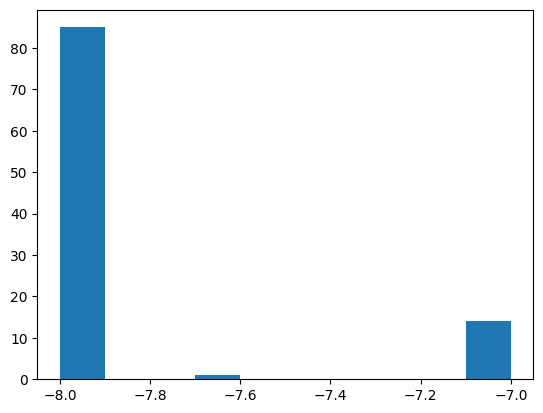

In [68]:
# Coding Step 5

# We do very simple analysis here
# First, we output all the runs that do not reach the global maximum
# Second, we plot a histogram of all the runs to see what percent reach the global minimum

exp_val_short=[]
for i in range(num):
    if (exp_val[i] > -7.5):  # currently prints out runs stuck in a local minimum.  Change to < to get the global minimum runs
        print("Run:  ", i,"   Exp Val:  ", np.round(exp_val[i],2), "      Quasi Dist:  ", sample_val[i].quasi_dists)
    exp_val_short.append(np.round(exp_val[i],2))

plt.hist(exp_val_short)

# Analysis

Recall that attendee 1 prefers events 1 and 4, attendee 2 prefers events 2 and 3, attendee 3 prefers events 3 and 4, and attendee 4 prefers events 4 and 5.

See the table of 1) sample decimal values of the classical bit streams with a range of 0 - 31 corresponding to the 5 bits associated with the 5 events, 2) the associated Hamiltonian value, and 3) the events to be held on Sunday for that decimal value.

| Decimal Value of Bit Stream |   Hamiltonian Value (-) |  Events on Sunday |
| --- | ---- | ---- |
| 5 (00101) |              7 |                3, 1 |
| 8 (01000) |             7  |                4 |
| 10 (01010) |             8 |                4, 2 |
| 11 (01011) |             7 |                4, 2, 1 |
| 12 (01100) |             7 |                4, 3 |
| 14 (01110) |             6 |                4, 3, 2 |
| 19 (10011) |             7 |                5, 2, 1  |
| 20 (10100) |             7 |                5, 3 |
| 21 (10101) |             8 |                5, 3, 1 |
| 23 (10111) |             7 |                5, 3, 2, 1 |
| 26 (11011) |             7 |                5, 4, 2 |


## Global minimum

Since the maximum number of events that can be attended by the four attendees is also 8, we know that we have achieved a global minimum if an expected value of Hamiltonian of -8 is obtained.  In the 100 runs, this global minimum is reached roughly 75% of the time.  This expectation value is reached when events 2 and 4 occur together on Sunday and events 1, 3, and 5 occur on Saturday.  This occurence corresponds to a bit stream value of 10 (01010).

In order to study the runs that do not attain the global minimums in more detail, the current output only prints the quasi distributions of runs with an expected value > -7.5 which one can modify as desired.  The histogram does include all 100 runs.

## Symmetry

Note that the mirror solution of having events 1, 3, and 5 occur on Sunday with a bit stream value of 21 (10101) also attains an expected value of -8.  The mirror of each classical bit stream output is its difference from 31.  For example, an output of 10 corresponds to events 2 and 4 being held on Sunday and its mirror is 31 - 10 = 21 which corresponded to events 1, 3, and 5 being held on Sunday.  The two solutions are equivalent to the problem as formulated.  The problem always has two solutions because the mirror one could just flip the events on Saturday and Sunday to obtain the same expected value of the Hamiltonian.

## Phase shifts

There are multiple possible ry gate combinations (final parameter settings) that can yield the same bit stream value.  As an example, ry gate rotations of pi and -pi will yield opposite probability amplitudes but the same measurement probabilities.  Similarly, a rotation of -2 times pi, 0, and 2 times pi will all yield a rotation of zero degrees.

## Quantum phenonmena or rounding error?

It is interesting to observe that even when the global minimum is reached there are some runs that have some non-zero quasi probability of not attaining that minimum.  This may due to the optimization algorithm timing out at its maximum iteration count or due to rounding error in the final parameters of the rotation gates specifically because pi is an irrational number.

However, for the runs that attain a local minimum value near 7, we do observe that most have a quasi distribution that is split between a decimal state of 8 (only event 4 on Sunday) and 12 (only events 3 and 4 on Sunday) with both having significant non-zero probabilities.  This suggests that in most local minimums there is superposition between at least two event states at these local minimums.

The observation that the quasi probabilities between states 8 and 12 appear to vary significantly between the local minimum runs requires further thought.  State 12 generally has a higher quasi probability than state 8 which may make sense as there are probably more descent paths leading to events 3 and 4 happening on Sunday than only event 4 happening on Sunday.

Initially, the initial parameters were random numbers from (0, 1).  It was observed that the mirror of the (8, 12) superposition which would be a superposition of 19 and 23 was occurring much less frequently which warranted further investigation.  To be distributed across the entire state space, the initial parameter range was modified to (-pi, pi) which appeared to fix the the frequency imbalance between mirror superpostion states.  To add further randomness, one could also randomize the initial starting state for each run.
    
# Modification of the Hamiltonian to Obtain more Global Minimum Runs

Let's think about the original problem to gain some insight to see how we can modify the Hamiltonian to achieve better results.  Looking at the objective function before the variable transformation from x's to z's, notice that event 3 and event 4 are in the highest demand by the attendees.  So we would want to place these events on separate days.  Since there is one attendee that wants to go to both events, we can simply increase the coefficient of this term in the Hamiltonian to reduce the chances that events 3 and 4 occur on the same day.   We are effectively adding a penalty to the objective function to account for the added constraint.  This technique is similar to using Lagrangian coefficients in a traditional constrained optimization problem.  The table below shows that we do get our desired outcome as we increase the coefficient. 

| Coefficent | % at local minimums (approx) |
| ------ | ------ |
| 0.5 |      wide range 10-30 |
| 0.6 |      10 |
| 0.7 |      5  |
| 0.8 |      1  |

# Future areas of exploration

- Implement with RunTime to understand its benefits.

- Use other Qiskit optimizers with the quantum circuit to improve the likelihood of attaining the global minimum or balancing out outcomes for local minimum runs.  Perhaps experimenting with the number of iterations or larger step sizes will help.

- Occasionally, a run gets finds a minimum reasonably greater than -8 and reasonably less than -7.  Investigate how this occurs and what it may mean.

- Gain further insight by creating variations to the original problem such as 1) introducing more attendees or events, or 2) adding constraints to certain events or attendees and adjusting the Hamiltonian appropriately.

- Use other quantum algorithms to improve the likelihood of finding the global minimum.  Other methods could include quantum annealing or QAOA.  While it is difficult to perform quantum annealing within Qiskit, we can perform a QAOA implementation in hopes of improving the likelihood of achieving the global minimum.

- Run the circuit on an IBM Quantum Computer to understand the issues that arise from a noisy channel.